# Movielens Deep Neural Net model from scratch in PyTorch
> Training Pytorch MLP model on movielens-100k dataset and visualizing factors by decomposing using PCA

- toc: true
- badges: true
- comments: true
- categories: [Pytorch, Movie, MLP, NCF, Visualization]
- image:

In [ ]:
!pip install -U -q git+https://github.com/sparsh-ai/recochef.git

In [ ]:
import torch
from torch import nn
from torch import optim
from torch.nn import functional as F 
from torch.optim.lr_scheduler import _LRScheduler

from recochef.datasets.movielens import MovieLens
from recochef.preprocessing.encode import label_encode
from recochef.utils.iterators import batch_generator
from recochef.models.embedding import EmbeddingNet

import math
import copy
import pickle
import numpy as np
import pandas as pd
from textwrap import wrap
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
plt.style.use('ggplot')

## Data loading and preprocessing

In [ ]:
data = MovieLens()

In [ ]:
ratings_df = data.load_interactions()
ratings_df.head()

,USERID,ITEMID,RATING,TIMESTAMP
0,196,242,3.0,881250949
1,186,302,3.0,891717742
2,22,377,1.0,878887116
3,244,51,2.0,880606923
4,166,346,1.0,886397596


In [ ]:
movies_df = data.load_items()
movies_df.head()

,ITEMID,TITLE,RELEASE,VIDRELEASE,URL,UNKNOWN,ACTION,ADVENTURE,ANIMATION,CHILDREN,COMEDY,CRIME,DOCUMENTARY,DRAMA,FANTASY,FILMNOIR,HORROR,MUSICAL,MYSTERY,ROMANCE,SCIFI,THRILLER,WAR,WESTERN
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0


In [ ]:
ratings_df, maps = label_encode(ratings_df, ['USERID','ITEMID'])
ratings_df.head()

,USERID,ITEMID,RATING,TIMESTAMP
0,0,0,3.0,881250949
1,1,1,3.0,891717742
2,2,2,1.0,878887116
3,3,3,2.0,880606923
4,4,4,1.0,886397596


In [ ]:
X = ratings_df[['USERID','ITEMID']]
y = ratings_df[['RATING']]

## Unit tests

In [ ]:
for _x_batch, _y_batch in batch_generator(X, y, bs=4):
    print(_x_batch)
    print(_y_batch)
    break

tensor([[595, 652],
        [ 67, 154],
        [887, 284],
        [159, 665]])
tensor([[4.],
        [3.],
        [5.],
        [5.]])


In [ ]:
_x_batch[:, 1]

tensor([652, 154, 284, 665])

## Concepts

### Embedding Net

The PyTorch is a framework that allows to build various computational graphs (not only neural networks) and run them on GPU. The conception of tensors, neural networks, and computational graphs is outside the scope of this article but briefly speaking, one could treat the library as a set of tools to create highly computationally efficient and flexible machine learning models. In our case, we want to create a neural network that could help us to infer the similarities between users and predict their ratings based on available data.

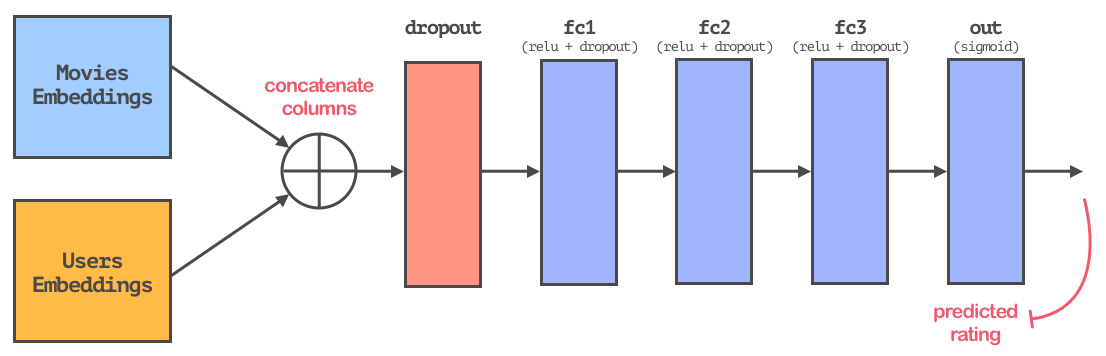

The picture above schematically shows the model we're going to build. At the very beginning, we put our embeddings matrices, or look-ups, which convert integer IDs into arrays of floating-point numbers. Next, we put a bunch of fully-connected layers with dropouts. Finally, we need to return a list of predicted ratings. For this purpose, we use a layer with sigmoid activation function and rescale it to the original range of values (in case of MovieLens dataset, it is usually from 1 to 5).

In [ ]:
netx = EmbeddingNet(
    n_users=50, n_items=20, 
    n_factors=10, hidden=[500], 
    embedding_dropout=0.05, dropouts=[0.5])
netx

EmbeddingNet(
  (u): Embedding(50, 10)
  (m): Embedding(20, 10)
  (drop): Dropout(p=0.05, inplace=False)
  (hidden): Sequential(
    (0): Linear(in_features=20, out_features=500, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
  )
  (fc): Linear(in_features=500, out_features=1, bias=True)
)

### Cyclical Learning Rate (CLR)

One of the `fastai` library features is the cyclical learning rate scheduler. We can implement something similar inheriting the `_LRScheduler` class from the `torch` library. Following the [original paper's](https://arxiv.org/abs/1506.01186) pseudocode, this [CLR Keras callback implementation](https://github.com/bckenstler/CLR), and making a couple of adjustments to support [cosine annealing](https://pytorch.org/docs/stable/optim.html#torch.optim.lr_scheduler.CosineAnnealingLR) with restarts, let's create our own CLR scheduler.

The implementation of this idea is quite simple. The [base PyTorch scheduler class](https://pytorch.org/docs/stable/_modules/torch/optim/lr_scheduler.html) has the `get_lr()` method that is invoked each time when we call the `step()` method. The method should return a list of learning rates depending on the current training epoch. In our case, we have the same learning rate for all of the layers, and therefore, we return a list with a single value. 

The next cell defines a `CyclicLR` class that expectes a single callback function. This function should accept the current training epoch and the base value of learning rate, and return a new learning rate value.

In [ ]:
class CyclicLR(_LRScheduler):
    
    def __init__(self, optimizer, schedule, last_epoch=-1):
        assert callable(schedule)
        self.schedule = schedule
        super().__init__(optimizer, last_epoch)

    def get_lr(self):
        return [self.schedule(self.last_epoch, lr) for lr in self.base_lrs]

Our scheduler is very similar to [LambdaLR](https://pytorch.org/docs/stable/optim.html#torch.optim.lr_scheduler.LambdaLR) one but expects a bit different callback signature. 

So now we only need to define appropriate scheduling functions. We're createing a couple of functions that accept scheduling parameters and return a _new function_ with the appropriate signature:

In [ ]:
def triangular(step_size, max_lr, method='triangular', gamma=0.99):
    
    def scheduler(epoch, base_lr):
        period = 2 * step_size
        cycle = math.floor(1 + epoch/period)
        x = abs(epoch/step_size - 2*cycle + 1)
        delta = (max_lr - base_lr)*max(0, (1 - x))

        if method == 'triangular':
            pass  # we've already done
        elif method == 'triangular2':
            delta /= float(2 ** (cycle - 1))
        elif method == 'exp_range':
            delta *= (gamma**epoch)
        else:
            raise ValueError('unexpected method: %s' % method)
            
        return base_lr + delta
        
    return scheduler

In [ ]:
def cosine(t_max, eta_min=0):
    
    def scheduler(epoch, base_lr):
        t = epoch % t_max
        return eta_min + (base_lr - eta_min)*(1 + math.cos(math.pi*t/t_max))/2
    
    return scheduler

To understand how the created functions work, and to check the correctness of our implementation, let's create a couple of plots visualizing learning rates changes depending on the number of epoch:

In [ ]:
def plot_lr(schedule):
    ts = list(range(1000))
    y = [schedule(t, 0.001) for t in ts]
    plt.plot(ts, y)

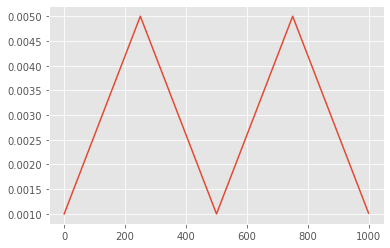

In [ ]:
plot_lr(triangular(250, 0.005))

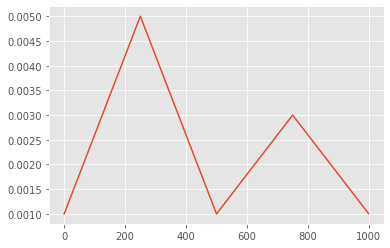

In [ ]:
plot_lr(triangular(250, 0.005, 'triangular2'))

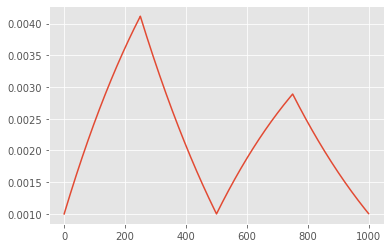

In [ ]:
plot_lr(triangular(250, 0.005, 'exp_range', gamma=0.999))

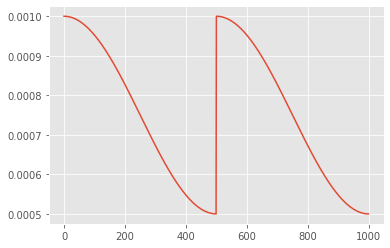

In [ ]:
plot_lr(cosine(t_max=500, eta_min=0.0005))

Note that cosine annealing scheduler is a bit different from other schedules as soon as it starts with `base_lr` and gradually decreases it to the minimal value while triangle schedulers increase the original rate.

## Training Loop

Now we're ready to start the training process. First of all, let's split the original dataset using [train_test_split](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) function from the `scikit-learn` library. (Though you can use anything else instead, like, [get_cv_idxs](https://github.com/fastai/fastai/blob/921777feb46f215ed2b5f5dcfcf3e6edd299ea92/fastai/dataset.py#L6-L22) from `fastai`).

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)
datasets = {'train': (X_train, y_train), 'val': (X_valid, y_valid)}
dataset_sizes = {'train': len(X_train), 'val': len(X_valid)}

In [ ]:
minmax = ratings_df.RATING.astype(float).min(), ratings_df.RATING.astype(float).max()
minmax

(1.0, 5.0)

In [ ]:
n_users = ratings_df.USERID.nunique()
n_movies = ratings_df.ITEMID.nunique()
n_users, n_movies

(943, 1682)

In [ ]:
net = EmbeddingNet(
    n_users=n_users, n_items=n_movies, 
    n_factors=150, hidden=[500, 500, 500], 
    embedding_dropout=0.05, dropouts=[0.5, 0.5, 0.25])

The next cell is preparing and running the training loop with cyclical learning rate, validation and early stopping. We use `Adam` optimizer with cosine-annealing learnign rate. The rate is decreased on each batch during `2` epochs, and then is reset to the original value.

Note that our loop has two phases. One of them is called `train`. During this phase, we update our network's weights and change the learning rate. The another one is called `val` and is used to check the model's performence. When the loss value decreases, we save model parameters to restore them later. If there is no improvements after `10` sequential training epochs, we exit from the loop.

In [ ]:
lr = 1e-3
wd = 1e-5
bs = 50
n_epochs = 100
patience = 10
no_improvements = 0
best_loss = np.inf
best_weights = None
history = []
lr_history = []

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

net.to(device)
criterion = nn.MSELoss(reduction='sum')
optimizer = optim.Adam(net.parameters(), lr=lr, weight_decay=wd)
iterations_per_epoch = int(math.ceil(dataset_sizes['train'] // bs))
scheduler = CyclicLR(optimizer, cosine(t_max=iterations_per_epoch * 2, eta_min=lr/10))

for epoch in range(n_epochs):
    stats = {'epoch': epoch + 1, 'total': n_epochs}
    
    for phase in ('train', 'val'):
        training = phase == 'train'
        running_loss = 0.0
        n_batches = 0
        
        for batch in batch_generator(*datasets[phase], shuffle=training, bs=bs):
            x_batch, y_batch = [b.to(device) for b in batch]
            optimizer.zero_grad()
        
            # compute gradients only during 'train' phase
            with torch.set_grad_enabled(training):
                outputs = net(x_batch[:, 0], x_batch[:, 1], minmax)
                loss = criterion(outputs, y_batch)
                
                # don't update weights and rates when in 'val' phase
                if training:
                    scheduler.step()
                    loss.backward()
                    optimizer.step()
                    lr_history.extend(scheduler.get_lr())
                    
            running_loss += loss.item()
            
        epoch_loss = running_loss / dataset_sizes[phase]
        stats[phase] = epoch_loss
        
        # early stopping: save weights of the best model so far
        if phase == 'val':
            if epoch_loss < best_loss:
                print('loss improvement on epoch: %d' % (epoch + 1))
                best_loss = epoch_loss
                best_weights = copy.deepcopy(net.state_dict())
                no_improvements = 0
            else:
                no_improvements += 1
                
    history.append(stats)
    print('[{epoch:03d}/{total:03d}] train: {train:.4f} - val: {val:.4f}'.format(**stats))
    if no_improvements >= patience:
        print('early stopping after epoch {epoch:03d}'.format(**stats))
        break

loss improvement on epoch: 1
[001/100] train: 0.9774 - val: 0.8950
loss improvement on epoch: 2
[002/100] train: 0.8521 - val: 0.8786
[003/100] train: 0.8771 - val: 0.8837
loss improvement on epoch: 4
[004/100] train: 0.8066 - val: 0.8694
[005/100] train: 0.8292 - val: 0.8727
loss improvement on epoch: 6
[006/100] train: 0.7565 - val: 0.8622
[007/100] train: 0.7914 - val: 0.8692
[008/100] train: 0.7143 - val: 0.8768
[009/100] train: 0.7511 - val: 0.9157
[010/100] train: 0.6693 - val: 0.8947
[011/100] train: 0.7083 - val: 0.8817
[012/100] train: 0.6220 - val: 0.9407
[013/100] train: 0.6652 - val: 0.9095
[014/100] train: 0.5790 - val: 0.9412
[015/100] train: 0.6265 - val: 0.9332
[016/100] train: 0.5393 - val: 0.9789
early stopping after epoch 016


## Metrics

To visualize the training process and to check the correctness of the learning rate scheduling, let's create a couple of plots using collected stats:

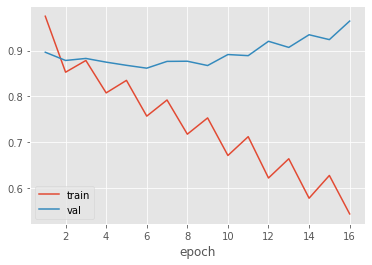

In [ ]:
ax = pd.DataFrame(history).drop(columns='total').plot(x='epoch')

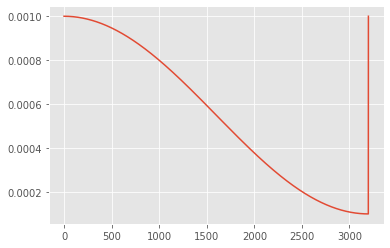

In [ ]:
_ = plt.plot(lr_history[:2*iterations_per_epoch])

As expected, the learning rate is updated in accordance with cosine annealing schedule.

The training process was terminated after _16 epochs_. Now we're going to restore the best weights saved during training, and apply the model to the validation subset of the data to see the final model's performance:

In [ ]:
net.load_state_dict(best_weights)

<All keys matched successfully>

In [ ]:
# groud_truth, predictions = [], []

# with torch.no_grad():
#     for batch in batch_generator(*datasets['val'], shuffle=False, bs=bs):
#         x_batch, y_batch = [b.to(device) for b in batch]
#         outputs = net(x_batch[:, 1], x_batch[:, 0], minmax)
#         groud_truth.extend(y_batch.tolist())
#         predictions.extend(outputs.tolist())

# groud_truth = np.asarray(groud_truth).ravel()
# predictions = np.asarray(predictions).ravel()

In [ ]:
# final_loss = np.sqrt(np.mean((predictions - groud_truth)**2))
# print(f'Final RMSE: {final_loss:.4f}')

In [ ]:
with open('best.weights', 'wb') as file:
    pickle.dump(best_weights, file)

## Bonus: Embeddings Visualization

Finally, we can create a couple of visualizations to show how various movies are encoded in embeddings space. Again, we're repeting the approach shown in the original post and apply the [Principal Components Analysis](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) to reduce the dimentionality of embeddings and show some of them with bar plots.

Loading previously saved weights:

In [ ]:
with open('best.weights', 'rb') as file:
    best_weights = pickle.load(file)
net.load_state_dict(best_weights)

<All keys matched successfully>

In [ ]:
def to_numpy(tensor):
    return tensor.cpu().numpy()

Creating the mappings between original users's and movies's IDs, and new contiguous values:

In [ ]:
user_id_map = maps['USERID_TO_IDX']
movie_id_map = maps['ITEMID_TO_IDX']
embed_to_original = maps['IDX_TO_ITEMID']

popular_movies = ratings_df.groupby('ITEMID').ITEMID.count().sort_values(ascending=False).values[:1000]

Reducing the dimensionality of movie embeddings vectors:

In [ ]:
embed = to_numpy(net.m.weight.data)
pca = PCA(n_components=5)
components = pca.fit(embed[popular_movies].T).components_
components.shape

(5, 1000)

Finally, creating a joined data frame with projected embeddings and movies they represent:

In [ ]:
movies = movies_df[['ITEMID','TITLE']].dropna()
movies.shape

(1682, 2)

In [ ]:
components_df = pd.DataFrame(components.T, columns=[f'fc{i}' for i in range(pca.n_components_)])
components_df.head()

,fc0,fc1,fc2,fc3,fc4
0,-0.009107,-0.033311,-0.063177,0.062377,-0.012594
1,-0.024497,-0.030063,0.012342,-0.012282,-0.001497
2,-0.047701,-0.027067,0.035245,-0.019496,0.016666
3,0.070064,-0.018393,0.018596,-0.020059,-0.019655
4,-0.050369,-0.031700,0.006050,-0.020357,-0.002196


In [ ]:
components_df.shape

(1000, 5)

In [ ]:
movie_ids = [embed_to_original[idx] for idx in components_df.index]
meta = movies.set_index('ITEMID')
components_df['ITEMID'] = movie_ids
components_df['TITLE'] = meta.loc[movie_ids].TITLE.values
components_df.sample(4)

,fc0,fc1,fc2,fc3,fc4,ITEMID,TITLE
634,-0.009766,0.029614,0.000689,-0.039898,-0.021887,424,Children of the Corn: The Gathering (1996)
650,-0.019740,-0.023809,-0.033855,-0.043130,-0.017906,1350,Crows and Sparrows (1949)
193,0.012680,0.018508,0.035511,-0.022324,0.017962,790,Tommy Boy (1995)
535,0.006801,0.015821,-0.033709,0.001635,-0.034954,644,"Thin Blue Line, The (1988)"


In [ ]:
def plot_components(components, component, ascending=False):
    fig, ax = plt.subplots(figsize=(18, 12))
    
    subset = components.sort_values(by=component, ascending=ascending).iloc[:12]
    columns = components_df.columns
    features = columns[columns.str.startswith('fc')].tolist()
    
    fc = subset[features]
    labels = ['\n'.join(wrap(t, width=10)) for t in subset.TITLE]
    
    fc.plot(ax=ax, kind='bar')
    y_ticks = [f'{t:2.2f}' for t in ax.get_yticks()]
    ax.set_xticklabels(labels, rotation=0, fontsize=14)
    ax.set_yticklabels(y_ticks, fontsize=14)
    ax.legend(loc='best', fontsize=14)
    
    plot_title = f"Movies with {['highest', 'lowest'][ascending]} '{component}' component values" 
    ax.set_title(plot_title, fontsize=20)

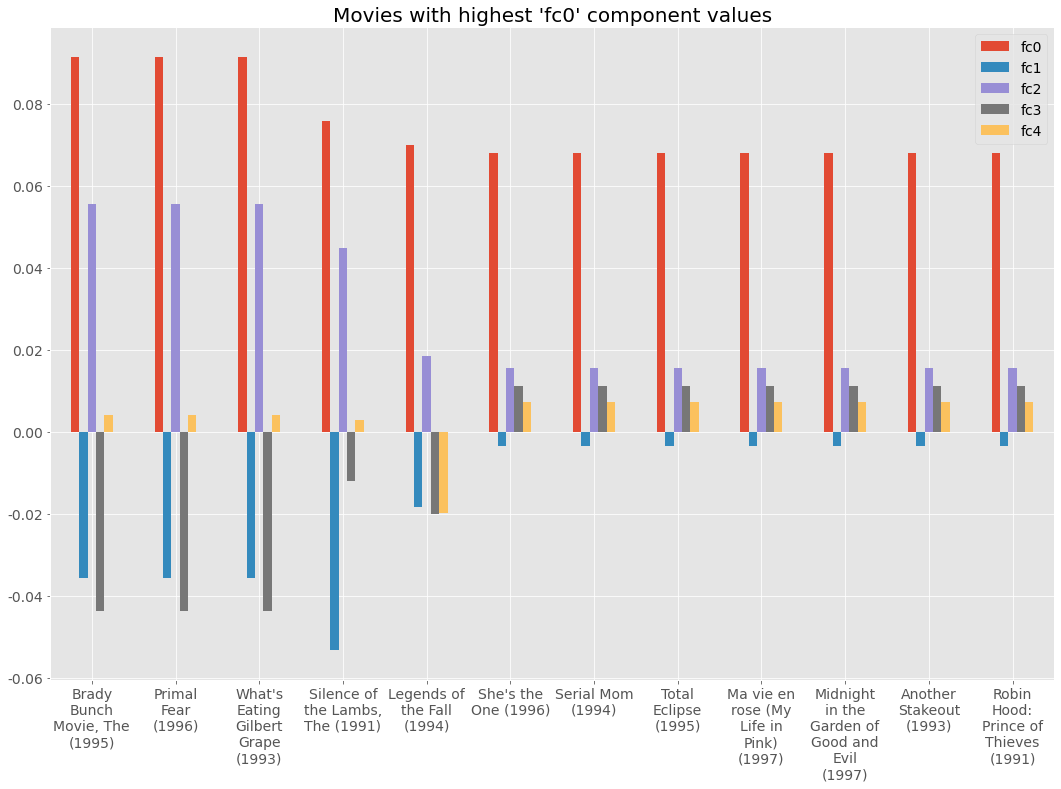

In [ ]:
plot_components(components_df, 'fc0', ascending=False)

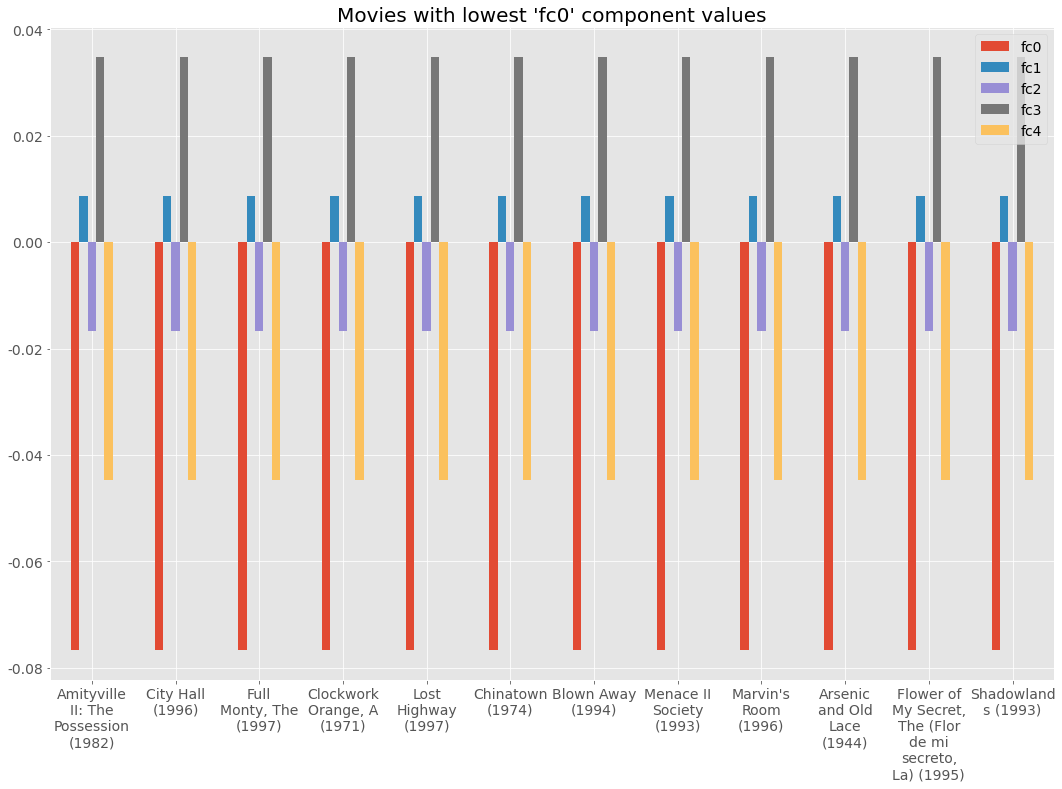

In [ ]:
plot_components(components_df, 'fc0', ascending=True)

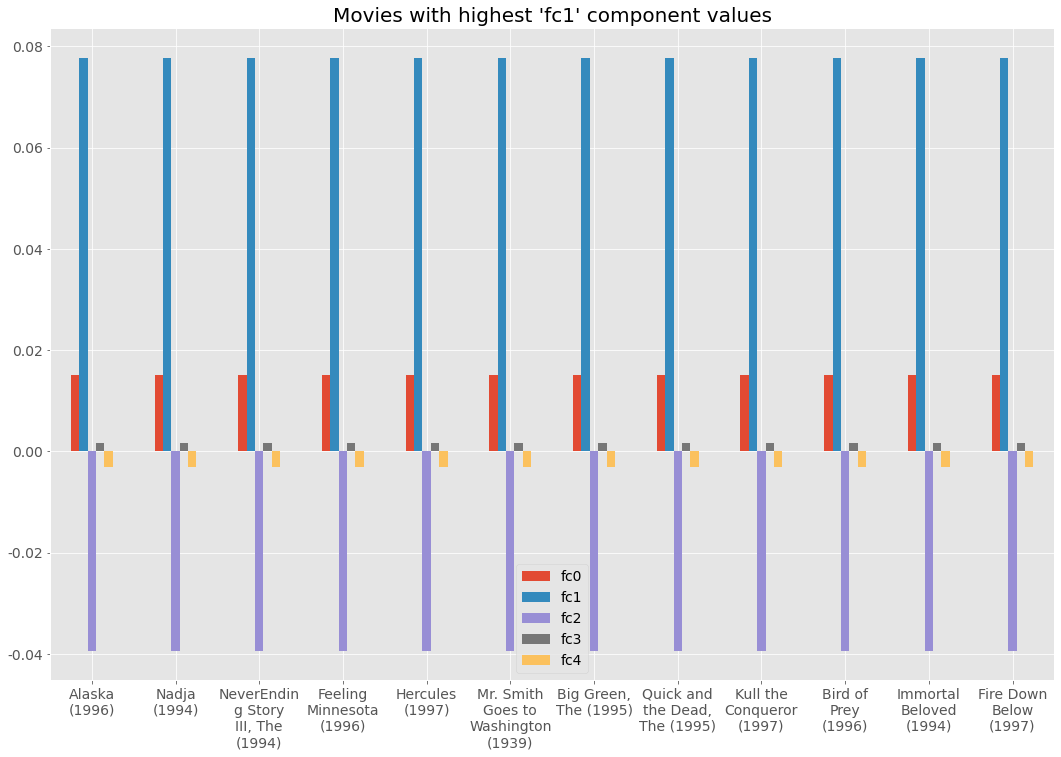

In [ ]:
plot_components(components_df, 'fc1', ascending=False)

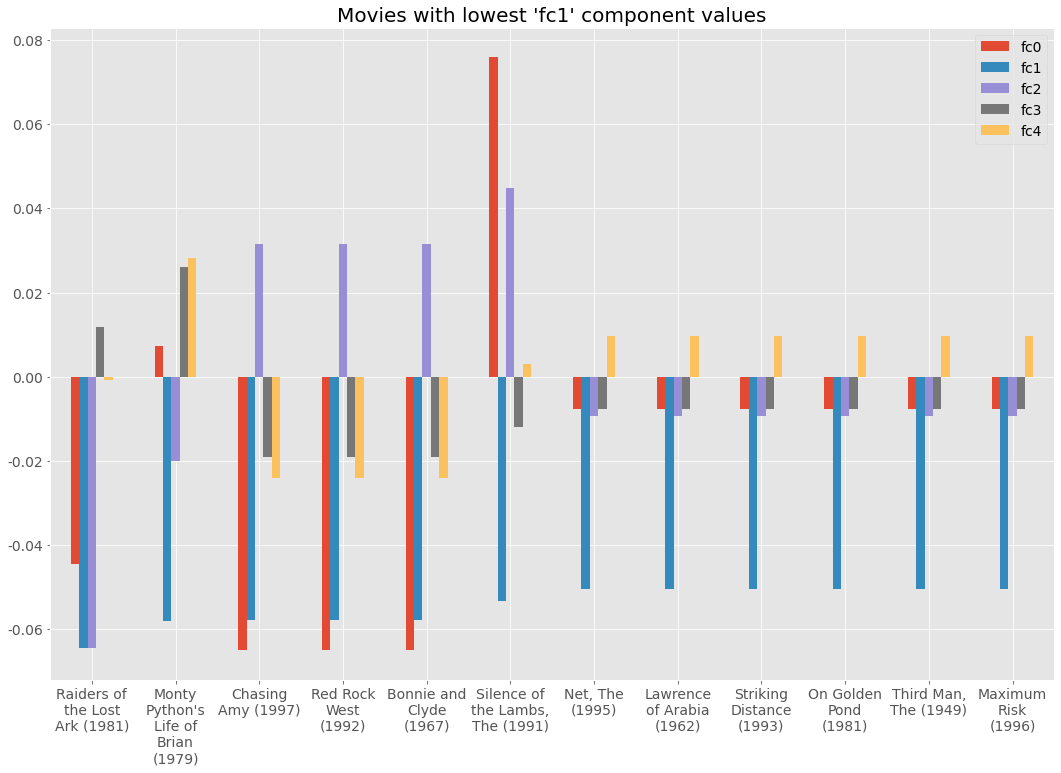

In [ ]:
plot_components(components_df, 'fc1', ascending=True)